# 🏋️ HUẤN LUYỆN MÔ HÌNH DỊCH (FINE-TUNING BARTpho)

---

### 🎯 Mục tiêu
Notebook này thực hiện quá trình tinh chỉnh (**Fine-tuning**) mô hình ngôn ngữ **BARTpho** (VinAI) cho bài toán dịch máy (Neural Machine Translation). Mục tiêu là xây dựng một mô hình cơ sở (Base Model) có khả năng chuyển đổi văn bản Tiếng Việt sang cấu trúc Gloss của Ngôn ngữ Ký hiệu.

### 📊 Thông tin cấu hình
* **Mô hình nền (Pre-trained Model):** `vinai/bartpho-word`. Đây là mô hình Sequence-to-Sequence (Seq2Seq) dựa trên kiến trúc BART, được huấn luyện trước trên lượng lớn dữ liệu tiếng Việt, giúp mô hình hiểu ngữ cảnh tốt hơn so với training từ đầu.
* **Dữ liệu huấn luyện:** Tập dữ liệu tổng quát `Corpus-Vie-VSL-10K` (10.000 cặp câu).
    * *Train:* 80% (8.000 câu)
    * *Validation:* 10% (1.000 câu)
    * *Test:* 10% (1.000 câu)
* **Siêu tham số chính (Hyperparameters):**
    * Learning Rate: 1e-5
    * Batch size: 16
    * Epochs: 10

### 📉 Đánh giá & Trực quan hóa
Hiệu suất mô hình được đánh giá qua từng Epoch sử dụng hai chỉ số tiêu chuẩn trong dịch máy:
1.  **BLEU Score:** Đo độ tương đồng giữa văn bản dịch và nhãn gốc.
2.  **WER (Word Error Rate):** Đo tỷ lệ lỗi từ.
Cuối cùng, quá trình huấn luyện sẽ được trực quan hóa bằng biểu đồ Loss (Training vs Validation).

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cài đặt thư viện
!pip install -q transformers torch datasets accelerate gspread oauth2client pandas scikit-learn sacrebleu datasets evaluate jiwer pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 69.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.auth import default
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback
import numpy as np
import evaluate
import jiwer
import matplotlib as plt

## Tiền xử lý dữ liệu

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/Corpus-Vie-VSL-10K-prefix.csv')

In [ ]:
print("Cột trong csv:", df.columns.tolist())
print("Số lượng cặp câu: ", len(df))
print("Ví dụ 5 dòng đầu:")
print(df.head())

Cột trong csv: ['input_text', 'target_text']
Số lượng cặp câu:  10000
Ví dụ 5 dòng đầu:
           input_text          target_text
0   vi: Tôi 19 tuổi .  vsl: ﻿Tôi tuổi 19 .
1    vi: Bạn tên gì ?    vsl: Bạn tên gì ?
2   vi: Ai biết bơi ?   vsl: Biết bơi ai ?
3  vi: Con gà ăn gì ?  vsl: Con gà ăn gì ?
4  vi: Mít thì ngọt .      vsl: Mít ngọt .


In [ ]:
# Chia dữ liệu thành train/val/test
train_df, tem_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(tem_df, test_size = 0.5, random_state = 42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 8000, Val: 1000, Test: 1000


In [ ]:
# Chuyển sang Hugging Face Dataset
dataset = {
    'train': Dataset.from_pandas(train_df[['input_text', 'target_text']]),
    'val': Dataset.from_pandas(val_df[['input_text', 'target_text']]),
    'test': Dataset.from_pandas(test_df[['input_text', 'target_text']])
}

## Triển khai mô hình BARTpho

In [ ]:
# Load Tokenizer và model BARTpho
model_name = 'vinai/bartpho-word'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to('cuda')

config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(64001, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(64001, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)


In [ ]:
# Hàm tokenize dữ liệu
def preprocess_function(examples):
  inputs = [text for text in examples['input_text']]
  targets = [text for text in examples['target_text']]

  model_inputs = tokenizer(inputs, max_length = 128, truncation = True, padding = 'max_length')

  # Tokenize targets
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, max_length = 128, truncation = True, padding = 'max_length')

  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [ ]:
# Áp dụng tokenize cho Train, Val, Test
tokenized_datasets = {
    'train': dataset['train'].map(preprocess_function, batched = True),
    'val': dataset['val'].map(preprocess_function, batched = True),
    'test': dataset['test'].map(preprocess_function, batched = True)
}

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Định nghĩa thông số huấn luyện

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/BARTpho/model_checkpoints',
    eval_strategy = 'steps',
    eval_steps = 500,
    learning_rate = 5e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    weight_decay = 0.01,
    save_total_limit = 3,
    num_train_epochs = 10,
    predict_with_generate = True,
    fp16 = True,
    logging_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/BARTpho/logs',
    logging_strategy = 'steps',
    logging_steps = 500,
    save_strategy = 'steps',
    save_steps = 500,
    load_best_model_at_end = True,
    report_to = 'none',
    metric_for_best_model = 'eval_loss',
    greater_is_better = False
)

## Đổi đánh giá bằng Epoch

In [ ]:
# Định nghĩa Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/BARTpho_Time2/model_checkpoints',
    eval_strategy = 'epoch',
    learning_rate = 1e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    weight_decay = 0.01,
    save_total_limit = 3,
    num_train_epochs = 10,
    predict_with_generate = True, # to generate text when evaluate
    fp16 = True,
    logging_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/BARTpho_Time2/logs',
    logging_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    report_to = 'none',
    metric_for_best_model = 'eval_loss',
    greater_is_better = False
)

### Định nghĩa hàm đánh giá bản dịch BLEU, WER

In [ ]:
# Gọi
bleu_metric = evaluate.load('sacrebleu')
wer_metric = evaluate.load('wer')

In [ ]:
# Hàm tính toán BLEU và WER
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  if isinstance(preds, tuple):
    preds = preds[0]

  # Xử lý các giá trị dự đoán không hợp lệ
  vocab_size = tokenizer.vocab_size
  preds = np.where(preds < 0, tokenizer.pad_token_id, preds)
  preds = np.where(preds >= vocab_size, tokenizer.pad_token_id, preds)

  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens = True)

  # Thay thế -100 trong nhãn bằng pad_token_id để decode
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens = True)

  # Loại bỏ khoảng trắng thừa
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [label.strip() for label in decoded_labels]

  # Tính toán
  bleu = bleu_metric.compute(predictions = decoded_preds, references = [[ref] for ref in decoded_labels])
  wer = wer_metric.compute(predictions = decoded_labels, references = decoded_preds)

  return {
      'bleu': bleu['score'],
      'wer': wer
  }

In [ ]:
# Tránh token IDs không hợp lệ, cấu hình tham số generate
gen_kwargs = {
    'max_length': 128,
    'num_beams': 4,
    'no_repeat_ngram_size': 2
}

In [ ]:
# Tạo trainer
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)]
)

/tmp/ipython-input-2721176360.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Huấn luyện
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Wer
1,0.186900,0.007051,95.256972,0.035614
2,0.005800,0.005716,96.251330,0.030580
3,0.003900,0.005564,95.986376,0.032360
4,0.002700,0.005782,96.119762,0.031679
5,0.001900,0.005589,96.306399,0.030481
6,0.001400,0.005735,96.582259,0.028775


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=3000, training_loss=0.03375645991166433, metrics={'train_runtime': 2173.7119, 'train_samples_per_second': 36.803, 'train_steps_per_second': 2.3, 'total_flos': 1.3002778607616e+16, 'train_loss': 0.03375645991166433, 'epoch': 6.0})

In [ ]:
# Đánh giá trên tập Test
test_results = trainer.evaluate(eval_dataset = tokenized_datasets['test'])
print("Kết quả đánh giá trên tập test: ", test_results)

Kết quả đánh giá trên tập test:  {'eval_loss': 0.006228672806173563, 'eval_bleu': 96.05467576008705, 'eval_wer': 0.033298282509638975, 'eval_runtime': 61.4952, 'eval_samples_per_second': 16.261, 'eval_steps_per_second': 1.024, 'epoch': 6.0}


In [ ]:
!pip install -q pandas matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)
train_logs = df_logs[df_logs['loss'].notna()].reset_index(drop=True)
eval_logs = df_logs[df_logs['eval_loss'].notna()].reset_index(drop=True)

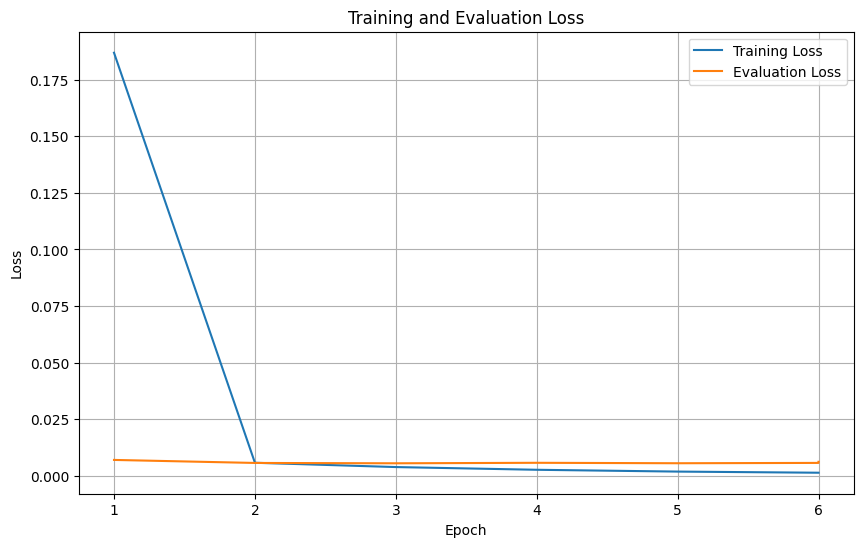

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_logs['epoch'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Evaluation Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

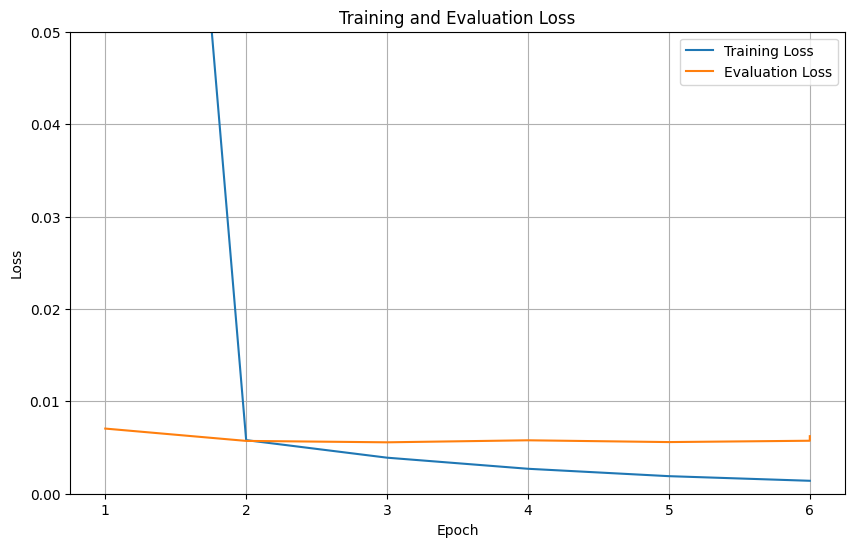

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(train_logs['epoch'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Evaluation Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0,0.05)
plt.show()

In [ ]:
output_model_dir = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/BARTpho/trained_model"
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Model saved to {output_model_dir}")

Model saved to /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/BARTpho/trained_model
